##  ML Project: Is every community note viewed as an attack?

### Unit of analysis
Each row will give details about a specific user-entered note.

### What are you trying to predict?
We are trying to predict whether the Twitter community indicates that a certain community note is expected to be “spam, harassment, or abuse” or not.

### What will you use to make that prediction?
We’ll use features in three main groups: information about a tweet (what the community user says about it), information about the community member who wrote the note, and information about ratings. This includes Tweet ID, Participant ID, user enrollment status, classification of whether a tweet is misleading, and the other criteria of whether Twitter users label a community flag as helpful or not.


### How would this prediction be used in a decision-making context?
It would be useful to see to what degree community notes are successful in fostering an informed online discussion or whether it creates more confusion and divergences. For example, there is already a viewpoint that community notes are being used to target certain ideologies, and this furthers the notion that “big tech is out to censor _ the community” (e.g., conservative). This would be useful in decision-making contexts, such as platform policy for notes. The platform can adjust the policies based on the interactions between the Twitter users who post tweets and rate community notes and the community users who fact-check tweets. Insights from this analysis could contribute to improving user trust in platform moderation practices and bias mitigation, leading to a healthier and more inclusive online community.

### Data Cleaning

At first we read three files: ratings, notes, and user enrollment. They are merged by NoteID.

How does a post get a note?
Contributors can suggest a note on any post. Notes are then rated for helpfulness by other contributors. Notes are only shown on posts if they are rated helpful by enough people from different perspectives. See how Community Notes defines and uses differences of perspectives here.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
data = pd.read_csv("ratings_clean_small.csv")

In [ ]:
data.head(5)

#data['modelingPopulation'].unique()

,noteId,raterParticipantId,createdAtMillis_x,version,agree,disagree,helpfulnessLevel,helpfulOther,helpfulClear,helpfulGoodSources,...,trustworthySources,isMediaNote,participantId,enrollmentState,successfulRatingNeededToEarnIn,timestampOfLastStateChange,timestampOfLastEarnOut,modelingPopulation,modelingGroup,numberOfTimesEarnedOut
0,1761266554724131298,49D3EC9394CFA8D34858BA3B634DF8B13A29DF22F56E38...,1708756408185,2,0,0,HELPFUL,0,1,1,...,1.0,0.0,49D3EC9394CFA8D34858BA3B634DF8B13A29DF22F56E38...,earnedIn,5.0,1.709579e+12,1.0,CORE,11.0,0.0
1,1749115176345821522,FBFC3E6094D2E063FC95321B0284CDF9EDCCE347E8DC9E...,1705867550251,2,0,0,NOT_HELPFUL,0,0,0,...,1.0,0.0,FBFC3E6094D2E063FC95321B0284CDF9EDCCE347E8DC9E...,earnedIn,5.0,1.709579e+12,1.0,CORE,3.0,0.0
2,1657432813514240007,E9EE0EBEACD030DD0EB9F05ADFE1911B8436D0F8E326D1...,1684022553110,2,0,0,HELPFUL,0,1,1,...,1.0,0.0,E9EE0EBEACD030DD0EB9F05ADFE1911B8436D0F8E326D1...,earnedIn,5.0,1.709579e+12,1.0,CORE,13.0,0.0
3,1736556082275778776,348A77843E3CF15D4168233C9BA8DF97DFF472897A3797...,1702922758645,2,0,0,HELPFUL,0,0,1,...,1.0,0.0,348A77843E3CF15D4168233C9BA8DF97DFF472897A3797...,earnedIn,5.0,1.709579e+12,1.0,CORE,0.0,0.0
4,1490163276361125893,5892A70BD5BE4821799A83D926583520E5124C29C931FD...,1644126477998,2,0,0,HELPFUL,0,0,1,...,1.0,0.0,5892A70BD5BE4821799A83D926583520E5124C29C931FD...,earnedIn,5.0,1.709579e+12,1.0,CORE,13.0,0.0


In [ ]:
df = data.drop(['noteId', 'raterParticipantId', 'createdAtMillis_x', 'participantId',
                'timestampOfLastStateChange', 'timestampOfLastEarnOut', 'ratedOnTweetId',
                'noteAuthorParticipantId', 'createdAtMillis_y', 'tweetId', 'modelingPopulation',
                'helpfulnessLevel', 'modelingGroup', 'version'], axis = 1)

In [ ]:
df.head(5)

,agree,disagree,helpfulOther,helpfulClear,helpfulGoodSources,helpfulAddressesClaim,helpfulImportantContext,helpfulUnbiasedLanguage,notHelpfulOther,notHelpfulIncorrect,...,notMisleadingOther,notMisleadingFactuallyCorrect,notMisleadingOutdatedButNotWhenWritten,notMisleadingClearlySatire,notMisleadingPersonalOpinion,trustworthySources,isMediaNote,enrollmentState,successfulRatingNeededToEarnIn,numberOfTimesEarnedOut
0,0,0,0,1,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,earnedIn,5.0,0.0
1,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,earnedIn,5.0,0.0
2,0,0,0,1,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,earnedIn,5.0,0.0
3,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,earnedIn,5.0,0.0
4,0,0,0,0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,earnedIn,5.0,0.0


In [ ]:
df = pd.get_dummies(df, columns=['classification', 'enrollmentState'], drop_first=True)

In [ ]:
df.head(5)

,agree,disagree,helpfulOther,helpfulClear,helpfulGoodSources,helpfulAddressesClaim,helpfulImportantContext,helpfulUnbiasedLanguage,notHelpfulOther,notHelpfulIncorrect,...,notMisleadingClearlySatire,notMisleadingPersonalOpinion,trustworthySources,isMediaNote,successfulRatingNeededToEarnIn,numberOfTimesEarnedOut,classification_NOT_MISLEADING,enrollmentState_earnedIn,enrollmentState_earnedOutAcknowledged,enrollmentState_newUser
0,0,0,0,1,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,5.0,0.0,False,True,False,False
1,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,5.0,0.0,False,True,False,False
2,0,0,0,1,1,1,1,1,0,0,...,0.0,0.0,1.0,0.0,5.0,0.0,False,True,False,False
3,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,1.0,0.0,5.0,0.0,False,True,False,False
4,0,0,0,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,5.0,0.0,False,True,False,False


In [ ]:
df.iloc[:, 40:50].head()

""
0
1
2
3
4


### Spliting Data

In [ ]:
X = df.drop('notHelpfulSpamHarassmentOrAbuse', axis = 1)

y = df['notHelpfulSpamHarassmentOrAbuse']

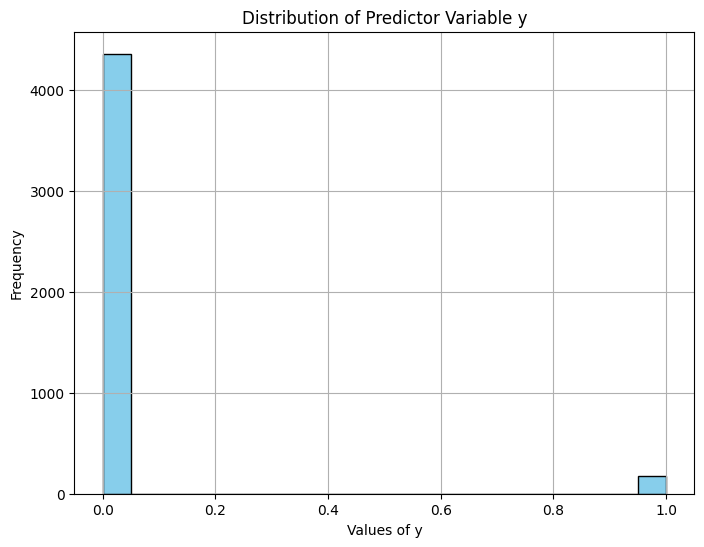

In [ ]:
# Plot a histogram of the predictor variable y
plt.figure(figsize=(8, 6))
plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values of y')
plt.ylabel('Frequency')
plt.title('Distribution of Predictor Variable y')
plt.grid(True)
plt.show()

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Selection

todo: get rid of helpfulness level NOT helpful, modeling group, modeling population, version

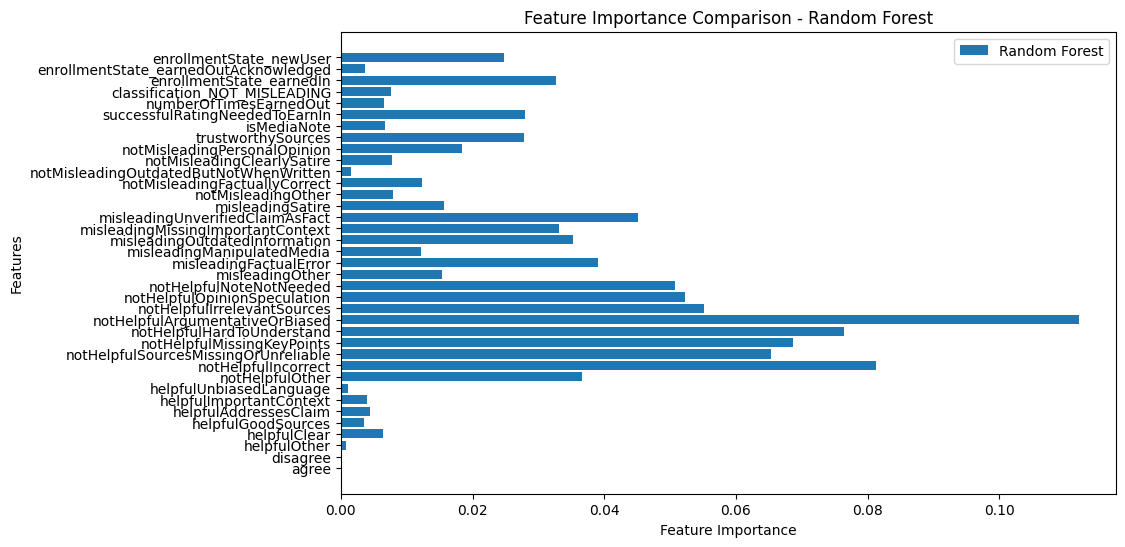

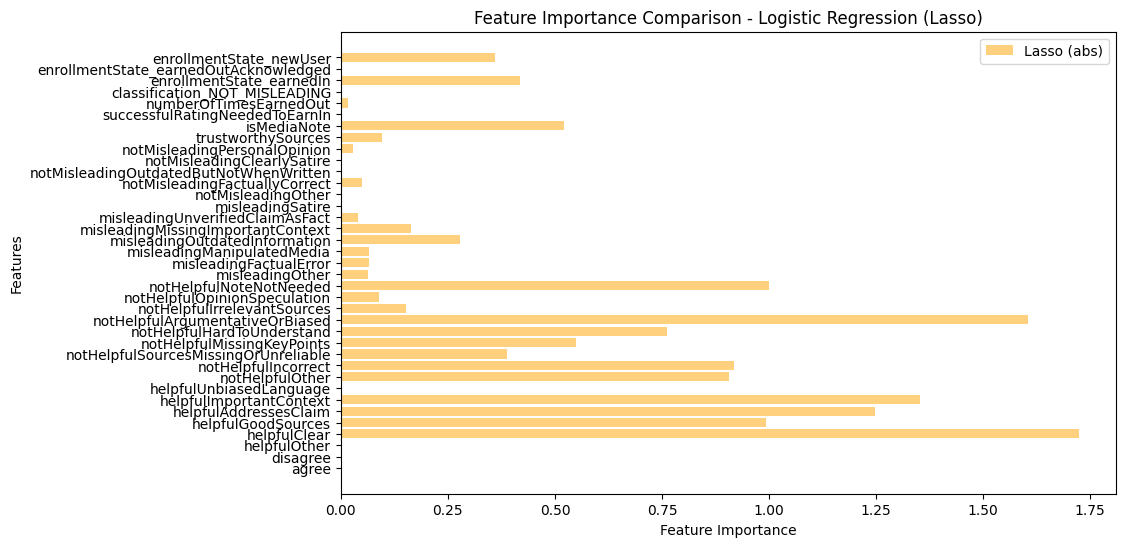

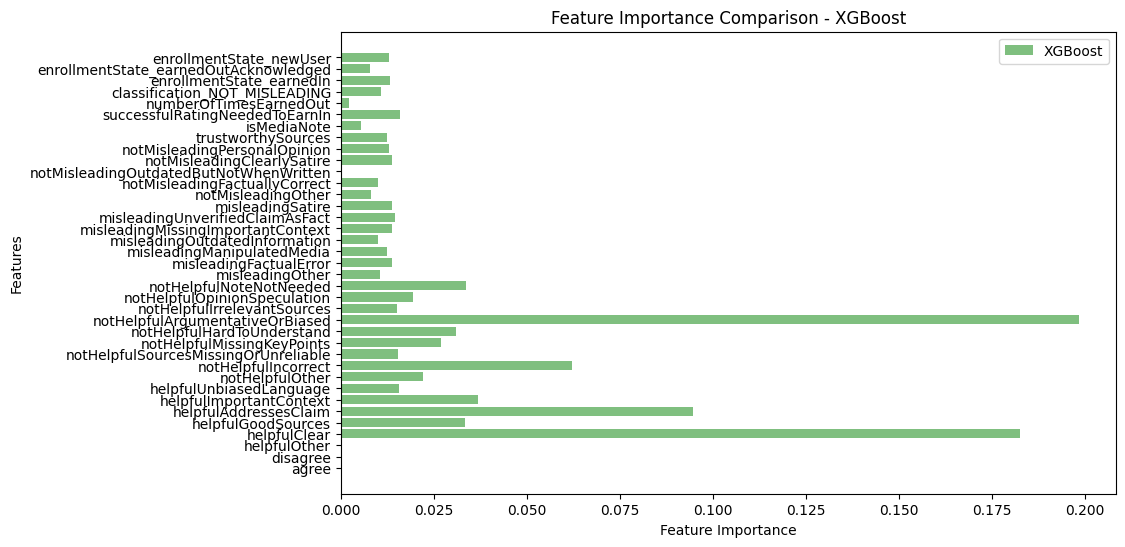

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imputed, y)

# Train Logistic Regression with L1 regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_imputed, y)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_imputed, y)

# Get feature names
feature_names = X.columns

# Get feature importance from each model
rf_feature_importance = rf.feature_importances_
lasso_feature_importance = lasso.coef_[0]
xgb_feature_importance = xgb.feature_importances_

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_feature_importance, label='Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - Random Forest')
plt.legend()
plt.show()

# Plot feature importance for Logistic Regression (Lasso)
plt.figure(figsize=(10, 6))
plt.barh(feature_names, abs(lasso_feature_importance), alpha=0.5, label='Lasso (abs)', color='orange')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - Logistic Regression (Lasso)')
plt.legend()
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importance, alpha=0.5, label='XGBoost', color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - XGBoost')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_feature_importance,
    'Lasso (L1 Regularization)': abs(lasso_feature_importance),
    'XGBoost': xgb_feature_importance
})

# Display the feature importance DataFrame
print("Feature Importance Comparison")
print(feature_importance_df)

Feature Importance Comparison
                                   Feature  Random Forest  \
0                                    agree       0.000000   
1                                 disagree       0.000000   
2                             helpfulOther       0.000763   
3                             helpfulClear       0.006331   
4                       helpfulGoodSources       0.003573   
5                    helpfulAddressesClaim       0.004456   
6                  helpfulImportantContext       0.003907   
7                  helpfulUnbiasedLanguage       0.001137   
8                          notHelpfulOther       0.036575   
9                      notHelpfulIncorrect       0.081332   
10    notHelpfulSourcesMissingOrUnreliable       0.065301   
11              notHelpfulMissingKeyPoints       0.068679   
12              notHelpfulHardToUnderstand       0.076427   
13         notHelpfulArgumentativeOrBiased       0.112109   
14             notHelpfulIrrelevantSources       0.0551

Features are grouped into three main types:

1. Tweet Information: Details about the specific tweet or community member note (e.g., Tweet ID, content classification).
2. User Information: Data on the community member who wrote the note (e.g., participant ID, enrollment status).
3. Rating Information: How other Twitter users perceive the helpfulness of the note.

In [ ]:
# Sort the feature importance DataFrame by Random Forest importance scores
feature_importance_df_sorted_rf = feature_importance_df.sort_values(by='Random Forest', ascending=False)

# Select the top 20 rows
top_20_rf = feature_importance_df_sorted_rf.head(20)

# Sort the feature importance DataFrame by Logistic Regression (Lasso) importance scores
feature_importance_df_sorted_lasso = feature_importance_df.sort_values(by='Lasso (L1 Regularization)', ascending=False)

# Select the top 20 rows
top_20_lasso = feature_importance_df_sorted_lasso.head(20)

# Sort the feature importance DataFrame by XGBoost importance scores
feature_importance_df_sorted_xgb = feature_importance_df.sort_values(by='XGBoost', ascending=False)

# Select the top 20 rows
top_20_xgb = feature_importance_df_sorted_xgb.head(20)

# Display the top 20 values for each model
print("Top 20 Feature Importance Comparison - Random Forest:")
print(top_20_rf)

Top 20 Feature Importance Comparison - Random Forest:
                                 Feature  Random Forest  \
13       notHelpfulArgumentativeOrBiased       0.112109   
9                    notHelpfulIncorrect       0.081332   
12            notHelpfulHardToUnderstand       0.076427   
11            notHelpfulMissingKeyPoints       0.068679   
10  notHelpfulSourcesMissingOrUnreliable       0.065301   
14           notHelpfulIrrelevantSources       0.055171   
15          notHelpfulOpinionSpeculation       0.052296   
16               notHelpfulNoteNotNeeded       0.050767   
22       misleadingUnverifiedClaimAsFact       0.045133   
18                misleadingFactualError       0.039031   
8                        notHelpfulOther       0.036575   
20         misleadingOutdatedInformation       0.035205   
21     misleadingMissingImportantContext       0.033060   
34              enrollmentState_earnedIn       0.032740   
31        successfulRatingNeededToEarnIn       0.027906   
29

Reasons for Variance in Feature Importance:

1. Model Structures:
* Random Forest is non-linear and bagging-based, whereas Lasso is linear, and XGBoost relies on boosting.
* These structural differences mean that each model type can handle interactions and nonlinear relationships differently, leading to different importance scores.
2. Feature Interaction Handling:
* Random Forest and XGBoost can capture feature interactions due to their tree-based structures.
* Lasso, being a linear model, can only estimate the effect of each feature independently.
3. Penalty (Regularization) Effects:
* Lasso imposes strict penalties that can shrink less influential features to zero, emphasizing only the most critical features.
* Random Forest and XGBoost don't apply penalties to individual features directly, providing a broader importance ranking.
4. Splitting Criteria:
* Random Forest and XGBoost use different criteria for splitting nodes (e.g., Gini impurity, entropy, etc.), affecting feature selection.

In [ ]:
a = X["notHelpfulArgumentativeOrBiased"]
counts = a.value_counts()
print(counts)

b = X["helpfulClear"]
count = b.value_counts()
print(count)

output = y
counts_y = output.value_counts()
print(counts_y)

notHelpfulArgumentativeOrBiased
0    18089
1     2290
Name: count, dtype: int64
helpfulClear
0    11537
1     8842
Name: count, dtype: int64
notHelpfulSpamHarassmentOrAbuse
0    19643
1      736
Name: count, dtype: int64


### Cross Validation

Ok so I guess it doesn't really matter if we use mean or median imputation.

Now let's tune the hyperparameters.

Best Hyperparameters for Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__solver': 'liblinear'}
Best Hyperparameters for Random Forest: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}
Best Hyperparameters for Decision Tree: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 10}
Best Hyperparameters for Support Vector Machine: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best Hyperparameters for Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 200}


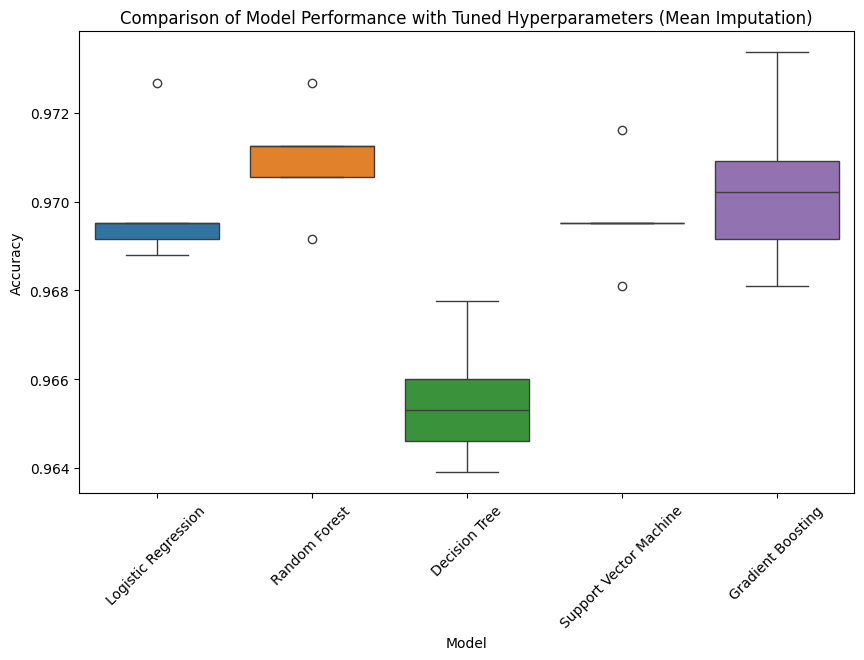

In [ ]:
# Define hyperparameters for each model
param_grid_lr = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'sag']
}

param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20]
}

param_grid_dt = {
    'decisiontreeclassifier__max_depth': [None, 10, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

param_grid_gb = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5]
}

# Create grid search objects for each model
grid_search_lr = GridSearchCV(models_mean_imputation['Logistic Regression'], param_grid_lr, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(models_mean_imputation['Random Forest'], param_grid_rf, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(models_mean_imputation['Decision Tree'], param_grid_dt, cv=5, scoring='accuracy')
grid_search_svc = GridSearchCV(models_mean_imputation['Support Vector Machine'], param_grid_svc, cv=5, scoring='accuracy')
grid_search_gb = GridSearchCV(models_mean_imputation['Gradient Boosting'], param_grid_gb, cv=5, scoring='accuracy')

# Perform grid search for each model
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_dt = grid_search_dt.best_params_
best_params_svc = grid_search_svc.best_params_
best_params_gb = grid_search_gb.best_params_

# Print the best hyperparameters for each model
print("Best Hyperparameters for Logistic Regression:", best_params_lr)
print("Best Hyperparameters for Random Forest:", best_params_rf)
print("Best Hyperparameters for Decision Tree:", best_params_dt)
print("Best Hyperparameters for Support Vector Machine:", best_params_svc)
print("Best Hyperparameters for Gradient Boosting:", best_params_gb)

# Use the best models with tuned hyperparameters for evaluation
best_model_lr = grid_search_lr.best_estimator_
best_model_rf = grid_search_rf.best_estimator_
best_model_dt = grid_search_dt.best_estimator_
best_model_svc = grid_search_svc.best_estimator_
best_model_gb = grid_search_gb.best_estimator_

# Perform cross-validation with the best models
cv_scores_lr = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(best_model_rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_dt = cross_val_score(best_model_dt, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_svc = cross_val_score(best_model_svc, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_gb = cross_val_score(best_model_gb, X_train, y_train, cv=5, scoring='accuracy')

# Store the results
results_best_models = {
    "Logistic Regression": cv_scores_lr,
    "Random Forest": cv_scores_rf,
    "Decision Tree": cv_scores_dt,
    "Support Vector Machine": cv_scores_svc,
    "Gradient Boosting": cv_scores_gb
}

# Visualize the performance of different models with mean imputation and tuned hyperparameters
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(results_best_models))
plt.title('Comparison of Model Performance with Tuned Hyperparameters (Mean Imputation)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create lists to store the results
model_names = []
hyperparameters_list = []
mean_accuracies = []

# Populate the lists with results
for model_name, cv_scores in results_best_models.items():
    mean_accuracy = cv_scores.mean()
    hyperparameters = ''
    if model_name == "Logistic Regression":
        hyperparameters = best_params_lr
    elif model_name == "Random Forest":
        hyperparameters = best_params_rf
    elif model_name == "Decision Tree":
        hyperparameters = best_params_dt
    elif model_name == "Support Vector Machine":
        hyperparameters = best_params_svc
    elif model_name == "Gradient Boosting":
        hyperparameters = best_params_gb

    model_names.append(model_name)
    hyperparameters_list.append(hyperparameters)
    mean_accuracies.append(mean_accuracy)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Hyperparameters': hyperparameters_list,
    'Mean Accuracy': mean_accuracies
})

# Display the results DataFrame
print("Model Performance and Hyperparameters (Mean Imputation):\n")
print(results_df)


Model Performance and Hyperparameters (Mean Imputation):

                    Model                                    Hyperparameters  \
0     Logistic Regression  {'logisticregression__C': 0.1, 'logisticregres...   
1           Random Forest  {'randomforestclassifier__max_depth': 10, 'ran...   
2           Decision Tree  {'decisiontreeclassifier__max_depth': 10, 'dec...   
3  Support Vector Machine                {'svc__C': 1, 'svc__kernel': 'rbf'}   
4       Gradient Boosting  {'gradientboostingclassifier__learning_rate': ...   

   Mean Accuracy  
0       0.969926  
1       0.970978  
2       0.965510  
3       0.969646  
4       0.970347  


### Random Forest seems to be the best performing classification model


In [ ]:
y_pred_rf = best_model_rf.predict(X_test)

# Generate classification report
report_rf = classification_report(y_test, y_pred_rf)

# Print the classification report
print("Classification Report for Random Forest:")
print(report_rf)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5914
           1       0.75      0.28      0.41       200

    accuracy                           0.97      6114
   macro avg       0.86      0.64      0.70      6114
weighted avg       0.97      0.97      0.97      6114



The best model should ideally balance false posiitves and false negatives, given the potential impact of incorrect classifications.

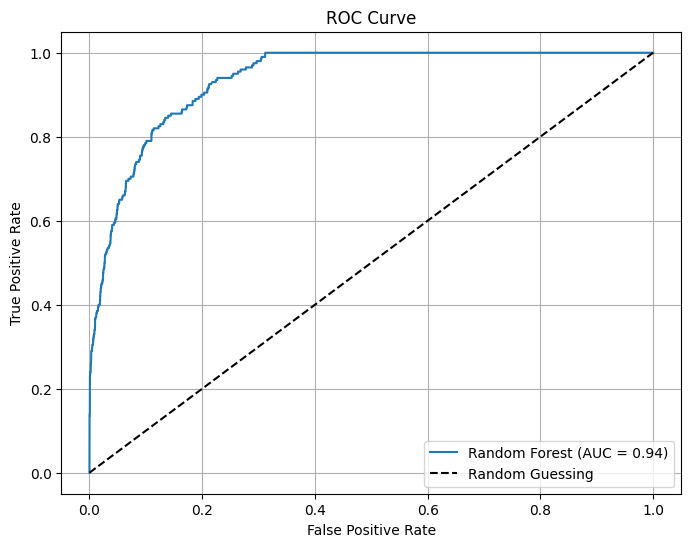

In [ ]:
# Calculate ROC-AUC scores
rf_proba = best_model_rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

# Calculate ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Ethical Considerations

potential biases and fairness concerns of the classification models

1. Bias and Fairness:
* Data Imbalance: With diverse features and an inherently subjective problem, the model should account for varying community standards.
* Transparency: Users should receive clear communication regarding why their notes were flagged, including any appeal mechanisms.
2. Privacy Concerns:
* Given sensitive data is involved, anonymization must be ensured, with ethical data sharing practices adhered to.
3. Societal Impact:
* This classification system influences public discourse directly. The model should be updated regularly and include human moderation in ambiguous cases to ensure fairness and accuracy.

In [ ]:
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'sag']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Create model instances
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
svc = SVC()
gb = GradientBoostingClassifier()

# Create grid search objects for each model
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy')

# Perform grid search for each model
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_dt = grid_search_dt.best_params_
best_params_svc = grid_search_svc.best_params_
best_params_gb = grid_search_gb.best_params_

# Print the best hyperparameters for each model
print("Best Hyperparameters for Logistic Regression:", best_params_lr)
print("Best Hyperparameters for Random Forest:", best_params_rf)
print("Best Hyperparameters for Decision Tree:", best_params_dt)
print("Best Hyperparameters for Support Vector Machine:", best_params_svc)
print("Best Hyperparameters for Gradient Boosting:", best_params_gb)

# Use the best models with tuned hyperparameters for evaluation
best_model_lr = grid_search_lr.best_estimator_
best_model_rf = grid_search_rf.best_estimator_
best_model_dt = grid_search_dt.best_estimator_
best_model_svc = grid_search_svc.best_estimator_
best_model_gb = grid_search_gb.best_estimator_

# Perform cross-validation with the best models
cv_scores_lr = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(best_model_rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_dt = cross_val_score(best_model_dt, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_svc = cross_val_score(best_model_svc, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_gb = cross_val_score(best_model_gb, X_train, y_train, cv=5, scoring='accuracy')

# Store the results
results_best_models = {
    "Logistic Regression": cv_scores_lr,
    "Random Forest": cv_scores_rf,
    "Decision Tree": cv_scores_dt,
    "Support Vector Machine": cv_scores_svc,
    "Gradient Boosting": cv_scores_gb
}

# Visualize the performance of different models with tuned hyperparameters
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(results_best_models))
plt.title('Comparison of Model Performance with Tuned Hyperparameters')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()